In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import Constants as C
from PlotTool import PlotTool
from Loader import Loader
from Cuts import qlayerCut, firstHitInOuter, maxDistMaxDoms,balloonCut

from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
pt = PlotTool()


In [2]:
# Load the data and apply the baseline selection.  Keep only
# the features we are going to use

b_features = ['hs_z_travel',
              'rho_travel',
              'ImpLF_rchi2',
              #'tlarge5[0]-tearly5[0]',
              'hm_nhit_doms',
              'hm_nhit_strings',
              'log10(hs_q_tot_pulses)',
              'maxDist',
              'cumuAt600ns',
              #'widthAt50',
              'hs_cogz',
              'sqrt(hs_cogx*hs_cogx+hs_cogy*hs_cogy)'
              ]

# Weigth branches for book keeping
weights = ['w','wE2','PrimaryNeutrinoEnergy','OneWeight','NEvents']

# Define the baseline selection
basesel = C.basesel + "&&(ImpLF_rchi2 > 80)"
#L3 = "&&(rho_travel < 250 && hs_z_travel > -200 && hs_z_travel < 100 && tlarge5[0]-tearly5[0] < 200)"
#L3 = "&&(hs_z_travel > -200 && hs_z_travel < 100 && tlarge5[0]-tearly5[0] < 200)"
L3 = '&&(tlarge5[0]-tearly5[0] < 200)'
basesel += L3

# Get data
loader = Loader(basesel)
d_nue  = loader.getNuE() 
d_cor  = loader.getCorsika()

# Insert the targets
d_nue['target'] = pd.Series(np.ones(len(d_nue['w']),dtype=int), index=d_nue.index)
d_cor['target'] = pd.Series(np.zeros(len(d_cor['w']),dtype=int), index=d_cor.index)

# Want to keep astro weights as well. Insert dummy astro
d_cor['wE2'] = d_cor['w']
d_cor['PrimaryNeutrinoEnergy'] = pd.Series(np.zeros(len(d_cor['w']),dtype=float), index=d_cor.index)

# Select outer events only
d_nue = qlayerCut(d_nue,False,0.8)
d_cor = qlayerCut(d_cor,False,0.8)

# Remove balloon events
d_nue = balloonCut(d_nue)
d_cor = balloonCut(d_cor)

# Only keep events that have hit in outer list
#d_nue = firstHitInOuter(d_nue)
#d_cor = firstHitInOuter(d_cor)

# Insert the maxdist var
d_nue['maxDist'] = maxDistMaxDoms(d_nue)
d_cor['maxDist'] = maxDistMaxDoms(d_cor)

# Separate high energy and low energy
d_he_nue = d_nue[np.log10(d_nue['PrimaryNeutrinoEnergy']) >= 6] 
d_le_nue = d_nue[np.log10(d_nue['PrimaryNeutrinoEnergy']) < 6]

# Select off only the features we want for training
d_he_nue = d_he_nue[ b_features + weights +['target'] ]
d_le_nue = d_le_nue[ b_features + weights +['target'] ]
d_cor    = d_cor[ b_features + weights + ['target'] ]


In [3]:
# Break into testing and training data sets
trainfrac = 0.8
X_nue_train, X_nue_test, y_nue_train, y_nue_test = train_test_split(d_he_nue[b_features+weights],
                                                                    d_he_nue['target'],
                                                                    train_size=trainfrac,
                                                                    random_state=194637)

X_cor_train, X_cor_test, y_cor_train, y_cor_test = train_test_split(d_cor[b_features+weights],
                                                                    d_cor['target'],
                                                                    train_size=trainfrac,
                                                                    random_state=194637)
X_nue_train['wE2'] *= 1./sum(X_nue_train['wE2'])
X_cor_train['wE2'] *= 1./sum(X_cor_train['wE2'])

# Now mix sig and bkg
X_train = X_nue_train.append(X_cor_train)
X_test  = X_nue_test.append(X_cor_test)
y_train = y_nue_train.append(y_cor_train)
y_test  = y_nue_test.append(y_cor_test)

# Adjust the weights
#X_train['w'] *= 1/trainfrac
X_test['w']  *= 1/(1-trainfrac)

#X_train['wE2'] *= 1/trainfrac
X_test['wE2']  *= 1/(1-trainfrac)

print "-------------------------"
print "Consistency check:"
print "Corsika: ", sum(X_train[ y_train < 0.5 ]['wE2']), sum(X_test[ y_test < 0.5 ]['w']) 
print "E^-2:    ", sum(X_train[ y_train > 0.5 ]['wE2']), sum(X_test[ y_test > 0.5 ]['wE2'])


-------------------------
Consistency check:
Corsika:  1.0 46119.8769232
E^-2:     1.0 0.366013398132


In [4]:
# Ok now we have our data separated and we can train our classifier
# In a separate script, do a grid search to best determine the hyper parameters.
# Here we can train the classifier

rs1 = 0 #9182734
rs2 = 47382 #918273 #564293

def classifier(ntrees,maxdepth,minsplit,learningrate,sl,maxfeat):

    # Using a BDT for now
    decisiontree = DecisionTreeClassifier(max_depth=maxdepth,
                                          min_samples_split=minsplit,
                                          max_features=maxfeat,
                                          min_samples_leaf=sl,
                                          random_state=rs1)
    clf = AdaBoostClassifier(decisiontree,
                             n_estimators=ntrees,
                             learning_rate=learningrate,
                             algorithm='SAMME.R',
                             random_state=rs2)
    return clf

def train(clf, X, y):
    global b_features
    clf.fit(X[ b_features ], y, sample_weight=X['wE2'].as_matrix())
    return clf

In [5]:
# Make a method to plot data and bkg
def plotbdt(clf, X_test, y_test):

    # Get the scores
    X_test['scores'] = pd.Series(clf.decision_function(X_test[b_features]),
                            index = X_test.index)

    # Divide up sig and bkg
    dt_sig = X_test[ y_test > 0.5 ]
    dt_bkg = X_test[ y_test < 0.5 ]

    # Now plot them
    sf = 365/34.7
    fig,ax = plt.subplots(ncols=1,figsize=(7,6))
    pt.ploth1(dt_sig['scores'].as_matrix(),
              dt_sig['wE2'].as_matrix(), # * sf,
              'BDT Score','Events / year / bin',
              r'Astro. $\nu_{e}$ (E>1PeV)',
              50,-1,1,'b',
              False,False)
    pt.ploth1(dt_bkg['scores'].as_matrix(),
              dt_bkg['w'].as_matrix(), # * sf,
              'BDT Score','Events / year / bin',
              r'Data (50%)',
              50,-1,1,'r',
              False,False)

    plt.grid()
    plt.legend(loc='best')
    #plt.plot([0.6,0.6],[1e-6,1e7],lw=2,ls='dashed',c='black')

    ax.set_yscale('log')

    # Let's also print out the expected sig 
    # and background for some cutvalues
    cuts = np.arange(0,1.0,0.05)
    for cut in cuts:
        print "Cut:", cut
        print "\tData: %f"%(sum(dt_bkg[ dt_bkg['scores'] > cut]['w'])*sf)
        print "\tAstro:   %f"%(sum(dt_sig[ dt_sig['scores'] > cut]['wE2'])*sf)


Cut: 0.0
	Data: 12825.764791
	Astro:   3.831311
Cut: 0.05
	Data: 3264.774027
	Astro:   3.822577
Cut: 0.1
	Data: 2201.228326
	Astro:   3.816457
Cut: 0.15
	Data: 917.963375
	Astro:   3.803980
Cut: 0.2
	Data: 917.455941
	Astro:   3.782775
Cut: 0.25
	Data: 591.744911
	Astro:   3.749374
Cut: 0.3
	Data: 443.558348
	Astro:   3.682233
Cut: 0.35
	Data: 443.512297
	Astro:   3.618780
Cut: 0.4
	Data: 441.630913
	Astro:   3.521678
Cut: 0.45
	Data: 441.630913
	Astro:   3.403543
Cut: 0.5
	Data: 441.630913
	Astro:   3.256185
Cut: 0.55
	Data: 441.630913
	Astro:   3.067446
Cut: 0.6
	Data: 441.630913
	Astro:   2.823055
Cut: 0.65
	Data: 441.630913
	Astro:   2.547650
Cut: 0.7
	Data: 441.630913
	Astro:   2.213220
Cut: 0.75
	Data: 0.000000
	Astro:   1.843366
Cut: 0.8
	Data: 0.000000
	Astro:   1.457292
Cut: 0.85
	Data: 0.000000
	Astro:   1.164454
Cut: 0.9
	Data: 0.000000
	Astro:   0.944792
Cut: 0.95
	Data: 0.000000
	Astro:   0.784897


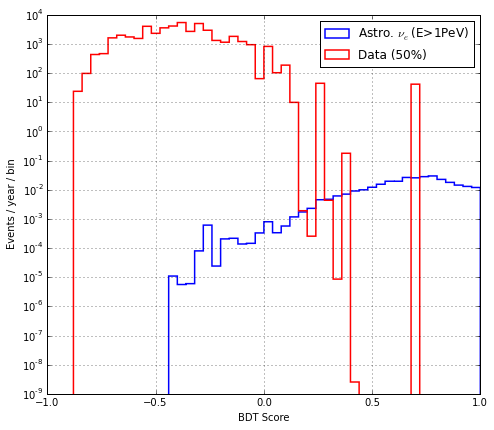

In [6]:
# Now define classifier, train, and plot
clf = classifier(300,4,1000,0.1,200,'sqrt')
clf = train(clf, X_train, y_train)
plotbdt(clf, X_test, y_test)

In [7]:
dt_sig = X_test[y_test > 0.5]
dt_bkg = X_test[y_test < 0.5]

In [10]:
print len(dt_bkg)

1822
9108


In [13]:
# Let's also bring in the data and remaining simulation and evaluate the bdt

# Grab missing files
d_numu = loader.getNuMu()
d_data = loader.getData()
d_data['w'] = pd.Series(np.ones(len(d_data['rho_travel'])),
                        index=d_data.index)

print "Total Data: ", len(d_data)

# apply some selection
d_numu = qlayerCut(d_numu, False, 0.8)
d_data = qlayerCut(d_data, False, 0.8)
#d_numu = firstHitInOuter(d_numu)
#d_data = firstHitInOuter(d_data)

# Cut balloon events
d_data = balloonCut(d_data)
d_numu = balloonCut(d_numu)

# Add the maxDist parameter
d_numu['maxDist'] = maxDistMaxDoms(d_numu)
d_data['maxDist'] = maxDistMaxDoms(d_data)

print "Total Data: ", len(d_data)

# Drop unnecessary stuff
d_numu = d_numu[ b_features + weights ]
d_data = d_data[ b_features + ['w','runid','evtid'] ]

print "Total Data: ", len(d_data), sum(d_data['w'])


Total Data:  123508
Total Data:  45862
Total Data:  45862 45862.0


In [14]:
# Clean up the data
d_data = d_data.dropna()
d_numu = d_numu.dropna()
d_le_nue = d_le_nue.dropna()

In [17]:
# Evaluate for data
d_data['scores'] = pd.Series(clf.decision_function( d_data[b_features] ), index=d_data.index)

# Evaluate for numu
d_numu['scores'] = pd.Series(clf.decision_function( d_numu[b_features] ), index=d_numu.index)

# Get LE nue that hasn't been used
d_le_nue['scores'] = pd.Series(clf.decision_function( d_le_nue[b_features] ), index=d_le_nue.index)

# Combine sim
dt_mc = pd.concat([dt_bkg, d_le_nue, dt_sig, d_numu])

# Put nue back together
dt_nue = pd.concat([d_le_nue, dt_sig])

In [18]:
# Build the info
info = {'data'     : [d_data, 
                      dt_mc, 
                      dt_bkg, 
                      dt_nue,
                      d_numu,
                      dt_nue,
                      d_numu],
        'names'    : ['Data',
                      'Total Bkg', 
                      r'Atmos. $\mu$',
                      r'Atmos. $\nu_{e}$', 
                      r'Atmos. $\nu_{\mu}$',
                      r'Astro. $\nu_{e}$',
                      r'Astro. $\nu_{\mu}$'],
        'weights' : ['w','w','w','w','w', 'wE2', 'wE2'], 
        'colors'  : ['black', 'r', 'm', 'g', 'b', 'y','c'],
        'lw'      : [0, 1.5, 1.5, 1.5, 1.5,1.5,1.5],
        'ls'      : ['solid','dashed','solid','solid','solid','solid','solid'],
        'marker'  : ['.',' ', ' ', ' ', ' ',' ',' ']
        }


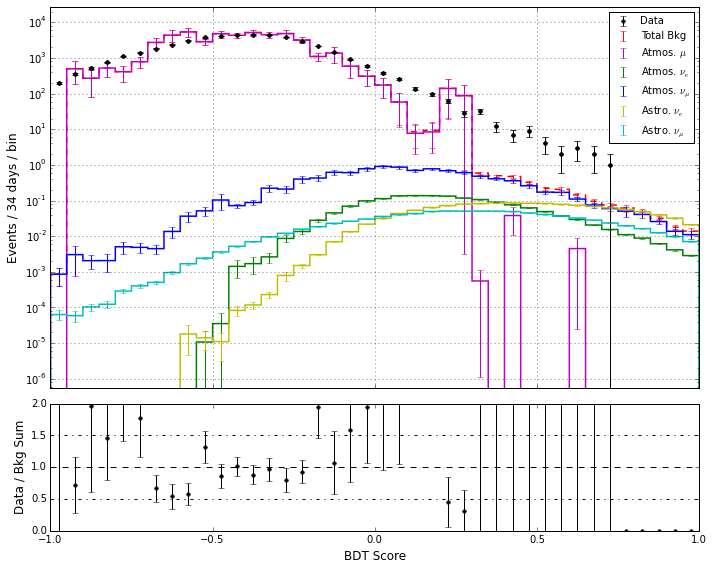

In [19]:
# Plot the scores
pt.plotStackedRatio(info,'scores','BDT Score', 40, -1, 1, 1e-10, True, False)
#plt.savefig('../plots/mvaana/bdts/datamc_bdtscore_secondpass.png')

In [24]:
peal = d_data[ d_data['scores'] > 0.65]
peal[['runid','evtid','log10(hs_q_tot_pulses)']]


,runid,evtid,log10(hs_q_tot_pulses)
21802,120460,10326738,3.683367
52253,120850,28525476,4.017584
56546,120880,63094230,3.062656


In [13]:
# Methods to plot effective area
from math import pi,log10

xmin  = 4
xmax  = 7
nbins = 15.
bins = np.arange(3,9.1,0.3)
ebins_per_decade = float(nbins/(xmax-xmin))
solidangle = 4*pi

def mcLogEBin(E):
    return int(log10(E)*ebins_per_decade)
def mcEMin(mc_log_ebin):
    return pow(10,mc_log_ebin/ebins_per_decade)
def mcEMax(mc_log_ebin):
    return pow(10,(1+mc_log_ebin)/ebins_per_decade)

# Calculate effective area
def getEffA(data, isbdt):
    effA = np.zeros(len(data['PrimaryNeutrinoEnergy']),dtype=float)
    energy = np.empty(len(data['PrimaryNeutrinoEnergy']),dtype=float)        
    fnorm  = 1. / (C.nugen_nue_nfiles)
    
    dt_E = data['PrimaryNeutrinoEnergy'].as_matrix()
    dt_oneweight = data['OneWeight'].as_matrix()
    dt_nevents   = data['NEvents'].as_matrix()
    for i in range(len(effA)):

        E = dt_E[i]
        OneWeight = dt_oneweight[i]
        NEvents   = dt_nevents[i]
        mclogebin = mcLogEBin(E)
        mcemin = mcEMin(mclogebin)
        mcemax = mcEMax(mclogebin)
        
        sf = 1
        if isbdt and np.log10(E) >=6:
            sf = 1/0.2 # This shouldn't be hard-coded!!!
        
        
        effA[i] = 1e-4 * OneWeight * fnorm/NEvents * 1/(solidangle*(mcemax-mcemin)) * sf
        energy[i] = log10(E)

    return effA, energy

def plotEffA(nrg, effa, col, lbl,ls='solid'):
        plt.hist(nrg,
                 weights=effa,
                 color=col,
                 label=lbl,
                 range=(xmin,xmax),
                 bins = nbins,
                 histtype='step',
                 lw = 1.5,
                ls = ls)


2.99436801515


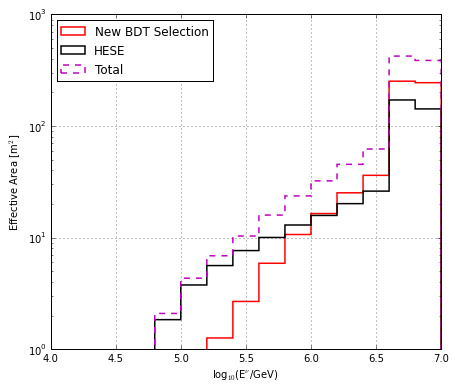

In [16]:
# Now plot the effective area for nu_e events from HESE
# and those passing the new BDT selection

# Load the hese data set
heseloader = Loader('(passHESE)')
dt_hese = heseloader.getNuE()

# Select off the nue events that pass the bdt cut
bdtcut = 0.6
nue_pass = dt_nue[ dt_nue['scores'] > bdtcut]
print sum(nue_pass['wE2']) *365/34.7

# Now evaluate effective area
new_effa, new_e = getEffA(nue_pass, True)
hese_effa, hese_e = getEffA(dt_hese, False)

# Now plot
fig,ax = plt.subplots(figsize=(7,6))
plotEffA(new_e, new_effa, 'r', 'New BDT Selection')
plotEffA(hese_e, hese_effa, 'black', 'HESE')
plotEffA(np.concatenate([new_e, hese_e]),
         np.concatenate([new_effa, hese_effa]),
         'm', 'Total','dashed')

ax.set_ylim([1e0,1e3])
ax.set_yscale('log')
plt.xlabel(r'log$_{10}$(E$^{\nu}$/GeV)')
plt.ylabel(r'Effective Area [m$^{2}$]')
plt.grid()
plt.legend(loc='upper left')
plt.savefig('../plots/mvaana/EffectiveArea/effasecondpass.png')

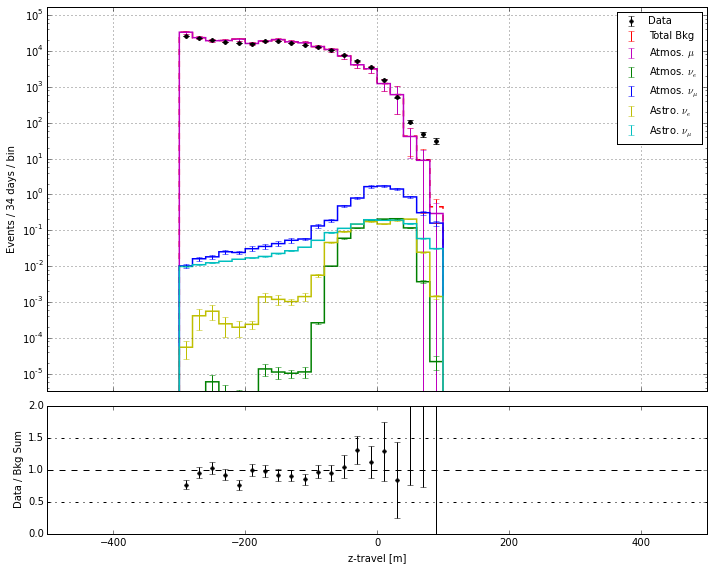

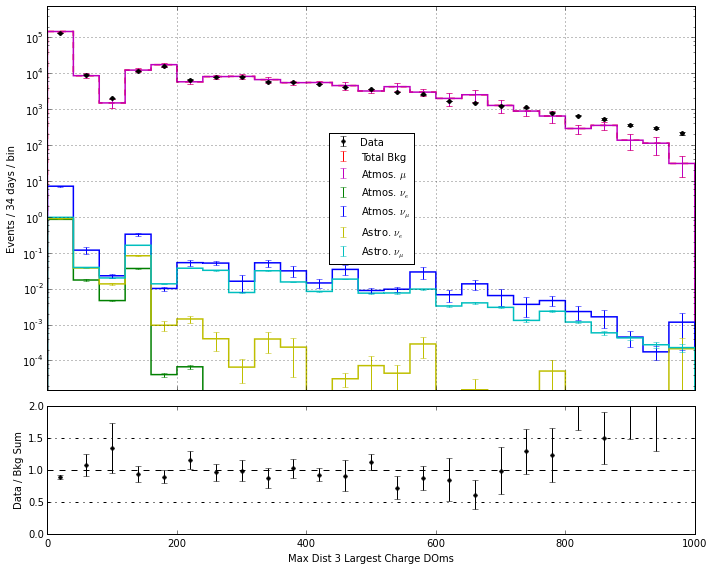

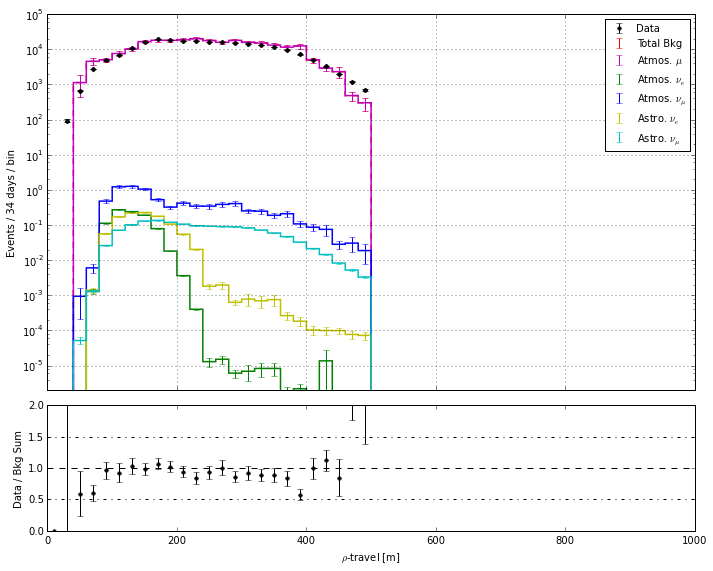

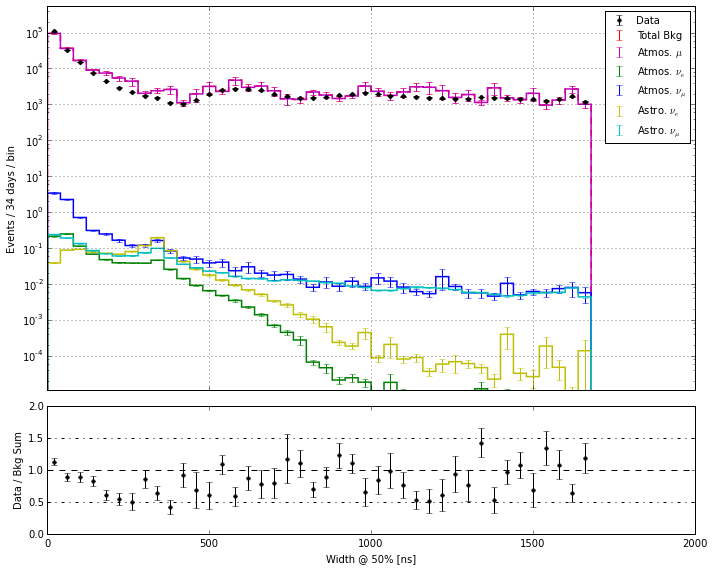

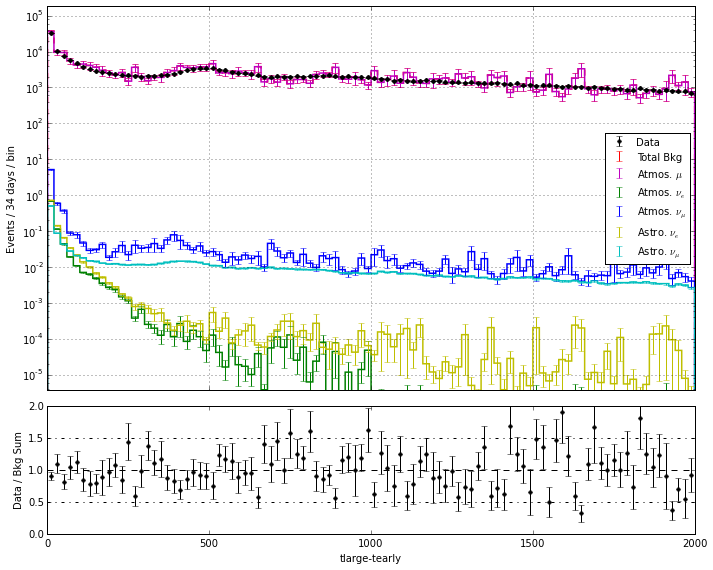

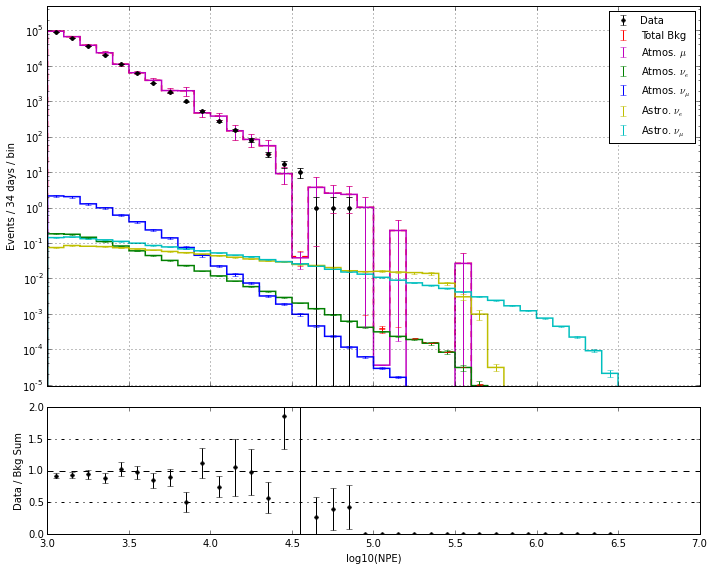

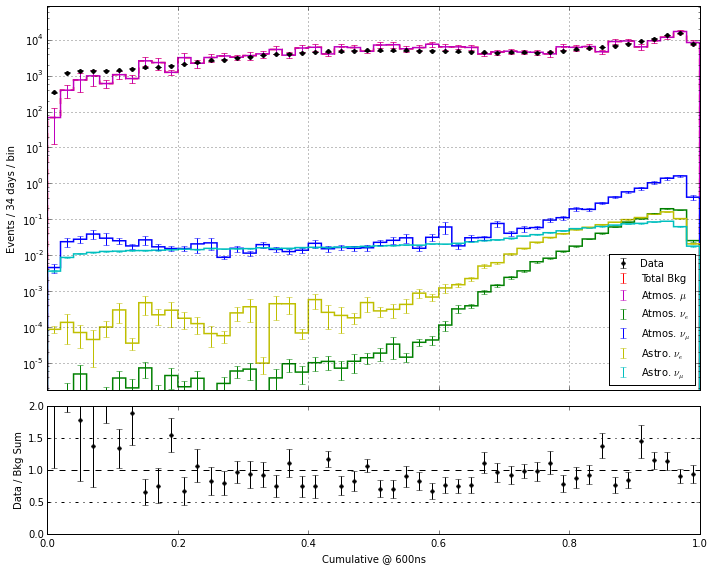

In [131]:
# Let's look at the plots to make sure I am feeding in 
# what I think I am feeding in
# Now drop in some stacked plots that we want to understand
variables = {'hs_z_travel' : [50,-500,500, 'ztravel','z-travel [m]'],
             'rho_travel'  : [50, 0, 1000, 'rhotravel', r'$\rho$-travel [m]'],
             'log10(hs_q_tot_pulses)' : [40, 3, 7, 'logqtot','log10(NPE)'],
             #'log10(NPE)'     : [40, 3, 7, 'lognpe','log10(NPE) (portia)'],
             #'cos(ImpLF_zen)' : [30, -1, 1, 'coszen', r'cos($\theta$)'],
             #'qratio'         : [100,0,1,'qratio','qratio'],
             #'hm_nhit_doms'   : [50,0,1500, 'hitdoms', r'N Hit Doms'],
             #'Nch'            : [20,0,1500, 'Nch', 'N Channel (portia)'],
             #'firsthitout'    : [2,-0.5,1.5, 'firsthitout', 'First Hit Outer'],
             'tlarge5[0]-tearly5[0]'  : [100, 0, 2000, 'tEarlyMinusLarge', 'tlarge-tearly'],
             #'risetimelarge5cumu[0]'  : [40, 0, 400, 'risetime0Cumu','Risetime0 (Cumulative) [ns]'],
             #'risetimelarge5[0]'  : [40, 0, 400, 'risetime0','Risetime0 [ns]'],
             #'risetimelarge5cumu[1]'  : [40, 0, 400, 'risetime1Cumu','Risetime1 (Cumulative) [ns]'],
             #'risetimelarge5[1]'  : [40, 0, 400, 'risetime1','Risetime1 [ns]'],
             #'widthlarge5[0]' : [40,0,400,'width0','Width0 [ns]'],
             #'widthlarge5[1]' : [40,0,400,'width1','Width1 [ns]'],
             'cumuAt600ns' : [50,0,1,'cumuAt600ns','Cumulative @ 600ns'],
             'widthAt50' : [50,0,2000,'widthAt50','Width @ 50% [ns]'],
             'maxDist' : [25,0,1000,'maxDist','Max Dist 3 Largest Charge DOms']
            }

for var in variables:
    
    lims = variables[var]
    
    pt.plotStackedRatio(info, 
                        var, 
                        lims[4],
                        lims[0], lims[1], lims[2], 
                        1e-10,
                        True, False)

In [118]:
def cutCumu(dt):
    return dt[ dt['cumuAt600ns'] >= 0.5 ]

d_data = cutCumu(d_data)
dt_mc = cutCumu(dt_mc)
dt_bkg = cutCumu(dt_bkg)
dt_nue = cutCumu(d_nue)
d_numu = cutCumu(d_numu)


info = {'data'     : [d_data, 
                      dt_mc, 
                      dt_bkg, 
                      dt_nue,
                      d_numu,
                      dt_nue,
                      d_numu],
        'names'    : ['Data',
                      'Total Bkg', 
                      r'Atmos. $\mu$',
                      r'Atmos. $\nu_{e}$', 
                      r'Atmos. $\nu_{\mu}$',
                      r'Astro. $\nu_{e}$',
                      r'Astro. $\nu_{\mu}$'],
        'weights' : ['w','w','w','w','w', 'wE2', 'wE2'], 
        'colors'  : ['black', 'r', 'm', 'g', 'b', 'y','c'],
        'lw'      : [0, 1.5, 1.5, 1.5, 1.5,1.5,1.5],
        'ls'      : ['solid','dashed','solid','solid','solid','solid','solid'],
        'marker'  : ['.',' ', ' ', ' ', ' ',' ',' ']
        }

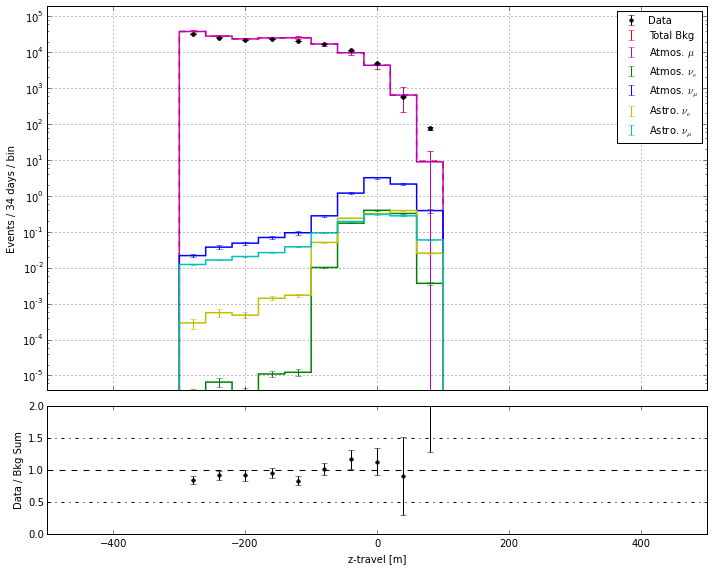

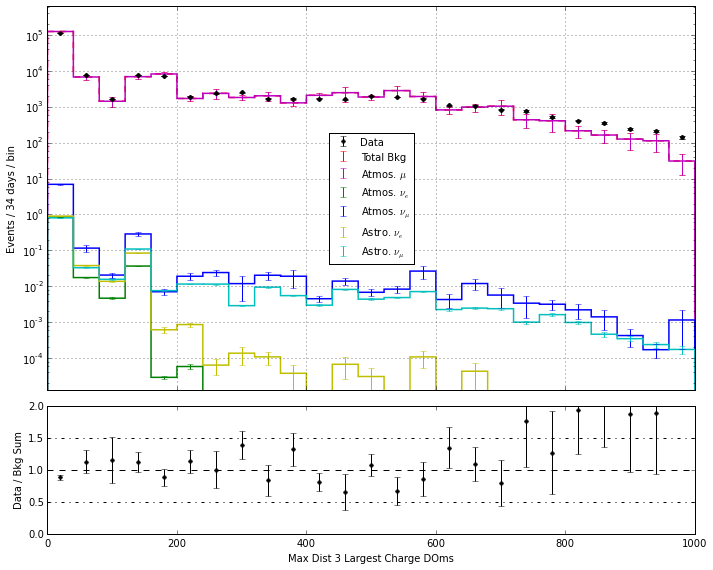

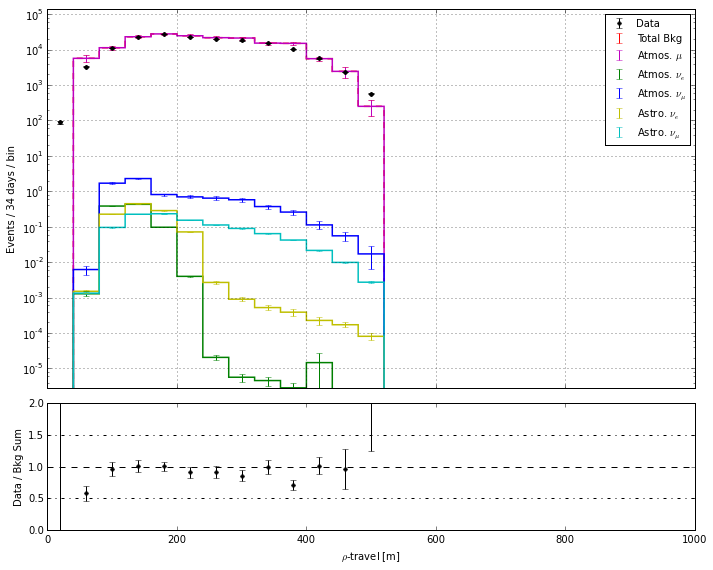

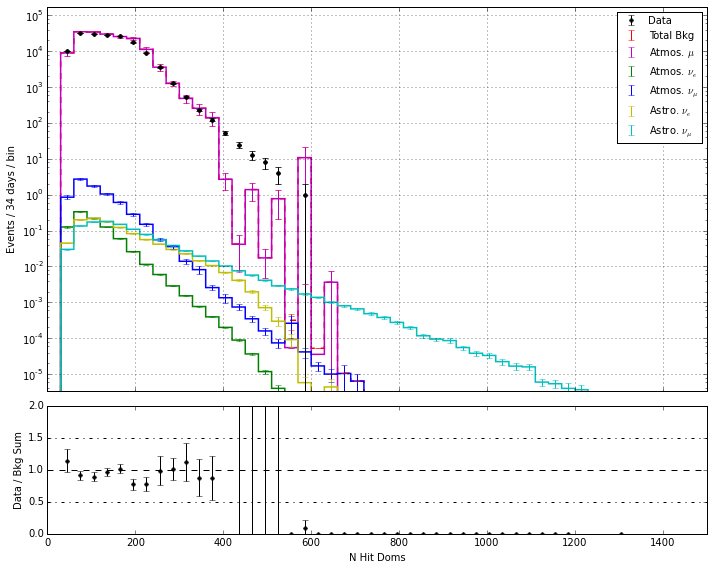

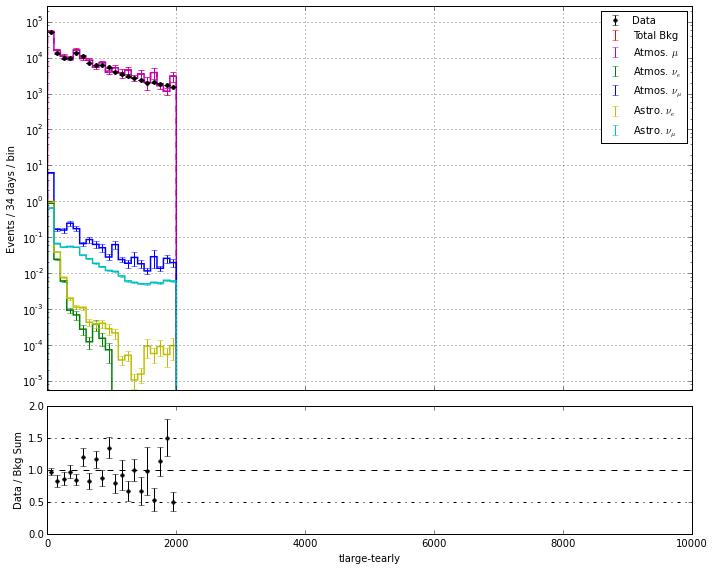

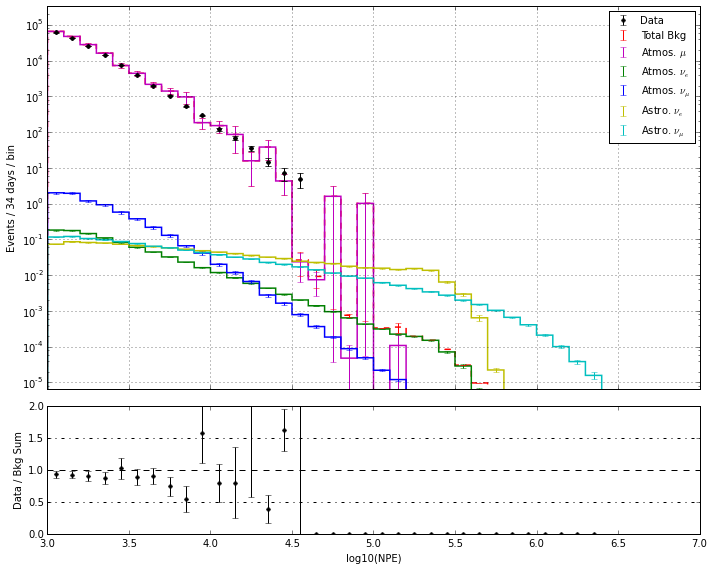

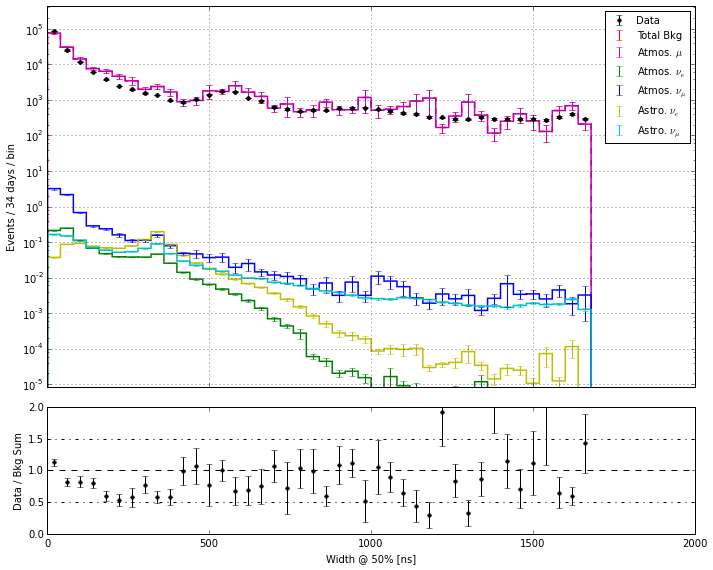

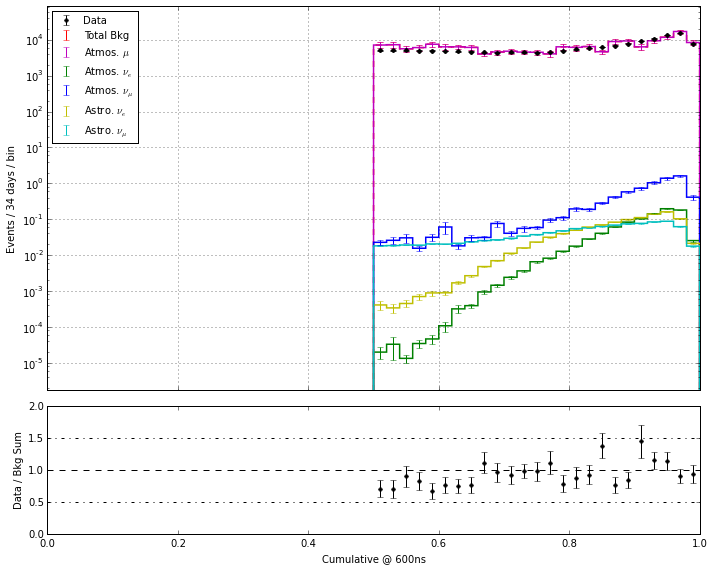

In [119]:
for var in variables:
    
    lims = variables[var]
    
    pt.plotStackedRatio(info, 
                        var, 
                        lims[4],
                        lims[0], lims[1], lims[2], 
                        1e-10,
                        True, False)